# LendingHome Case Study
by Jason Huang 
* Breif answers to questions

    Part 1:
    
    (1) Average Square feet of homes bought in California in 2014 AFTER DELETING 0s DATA is  1808.90
    
    (2) The number of distressed sales increased from 2010 and peaked at 2012, then decreased. It also shows seasonality in the data.
    
    (3) It is very noisy, but the profit tends to increase along with time passes by.
    
    Part 2:
    (1) Linear regression model and coefficients will be showed below. (Technique used: seasonality modeling, lasso penalty, feature selection, cross validation, backtesting)
    
    (2) Features to determine "arm' length transaction": price vs market price, seller and buyer's information, last sold time and price, general house condition.
    Model techniques that I will use are decision tree(ensemble tree, boosting tree), logistic classifier
    
    Part 3:
        please see below in the end of this notebook.
        
        
* Thank you for letting me work on this dataset and it is pretty interesing one! Really would like to work on the full set.
       

    


In [1]:
import graphlab
graphlab.canvas.set_target('ipynb')
import datetime as dt


In [2]:
SF_All_Data_raw = graphlab.SFrame.read_csv('RiskDataScientist_DataExercise_V2.csv')
# Converting date str to datetime
SF_All_Data_raw['txn_date'] = SF_All_Data_raw['txn_date'].apply(lambda date:\
                                                                dt.datetime.strptime(date, '%m/%d/%y'))
SF_All_Data_raw['txn_year'] = SF_All_Data_raw['txn_date'].apply(lambda date: date.year)
SF_All_Data_raw['txn_month'] = SF_All_Data_raw['txn_date'].apply(lambda date: date.month)

# Converting categorical variable
SF_All_Data_raw['construction_type'] = SF_All_Data_raw['construction_type'].astype(str)
SF_All_Data_raw['foundation_type'] = SF_All_Data_raw['foundation_type'].astype(str)

# Create distress_indicator_flag
SF_All_Data_raw['distress_indicator_flag'] = SF_All_Data_raw['distress_indicator'].apply(lambda x: 1 if x <> None else 0)
SF_All_Data_raw['distress_indicator_flag']  = SF_All_Data_raw['distress_indicator_flag'].fillna(0) 

print SF_All_Data_raw.column_types()
SF_All_Data_raw.head()



[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1487574377.log


This non-commercial license of GraphLab Create for academic use is assigned to itsjasonhuang@gmail.com and will expire on January 25, 2018.


Finished parsing file /Users/jialanzhang/Case_Study/LendingHome/RiskDataScientist_DataExercise_V2.csv

Parsing completed. Parsed 100 lines in 0.238602 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,str,str,str,str,int,int,str,str,int,int,str,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/jialanzhang/Case_Study/LendingHome/RiskDataScientist_DataExercise_V2.csv

Parsing completed. Parsed 96922 lines in 0.279761 secs.

[<type 'int'>, <type 'int'>, <type 'str'>, <type 'datetime.datetime'>, <type 'str'>, <type 'str'>, <type 'int'>, <type 'int'>, <type 'str'>, <type 'str'>, <type 'int'>, <type 'int'>, <type 'str'>, <type 'str'>, <type 'str'>, <type 'int'>, <type 'int'>, <type 'int'>, <type 'int'>]


Columns:
	txn_id	int
	property_id	int
	property_state	str
	txn_date	datetime
	buyer_name	str
	seller_name	str
	purchase_price	int
	loan_amt	int
	lender_name	str
	distress_indicator	str
	sqft	int
	yr_built	int
	property_type	str
	construction_type	str
	foundation_type	str
	exit_txn_id	int
	txn_year	int
	txn_month	int
	distress_indicator_flag	int

Rows: 10

Data:
+-----------+-------------+----------------+---------------------+
|   txn_id  | property_id | property_state |       txn_date      |
+-----------+-------------+----------------+---------------------+
| 559634942 |   70988076  |       FL       | 2015-11-05 00:00:00 |
| 339994350 |   38722313  |       CA       | 2012-10-16 00:00:00 |
| 435009706 |  121692603  |       FL       | 2014-09-15 00:00:00 |
| 337695188 |   30980030  |       CA       | 2012-09-14 00:00:00 |
| 553040506 |  119681557  |       TX       | 2015-07-28 00:00:00 |
| 419718880 |   30847672  |       CA       | 2014-07-18 00:00:00 |
| 320004653 |   30821512  |       CA       | 2011-11-30 00:00:00 |
| 487020929 |   24847540  |       CA       | 2015-01-29 00:00:00 |
| 281083176 |   26282301  |       CA       | 2010-01-06 00:00:00 |
| 375360450 |   27092028  |       CA       | 2013-12-02 00:00:00 |
+-----------+-------------+----------------+---------------------+
+--------------------------------+-----------------------------+----------------+
|           buyer_name           |         seller_name         | purchase_price |
+--------------------------------+-----------------------------+----------------+
|      LTD FAMILY TRUST LLC      | DEUTSCHE BK TRUST CO 2005-3 |     66200      |
|          NGUYEN,TONY           |    NOEGGERATH,MONTSERRAT    |     240000     |
| SOUTHEAST PROP ACQUISITIONS LL |    JP MORGAN CHASE BK NA    |     176200     |
|      WESTCLIFF REALTY LLC      |    US BK NA SERIES 2005-6   |     360000     |
|    SHAYLOOPA INVESTORS LLC     |        OLDHAM LARRY R       |       0        |
|     TROOST INVESTMENTS LLC     |  WISE SANDRA & W 1995 TRUST |     525000     |
|         LIONS HEAD LLC         |      PETERS,CHRISTOPHER     |     435000     |
|       JOHNSON,CHRISTINA        |       FOUTS,GREGORY L       |     190000     |
|         ANDREWS,DAVID          |  BIANCHI M & A FAMILY TRUST |     220000     |
|   NORTH AMERICAN ASSETS LLC    |         HILL SUZANNE        |     405000     |
+--------------------------------+-----------------------------+----------------+
+----------+---------------------------+--------------------+------+----------+
| loan_amt |        lender_name        | distress_indicator | sqft | yr_built |
+----------+---------------------------+--------------------+------+----------+
|    0     |                           |         S          | 1059 |   1959   |
|    0     |                           |         I          | 1255 |   1956   |
|  123287  | ARCHETYPE CREDIT OPPORTUN |        None        | 3170 |   2007   |
|    0     |                           |         S          | 2688 |   1977   |
|  26000   | BLUE MOON FUNDING GROUP L |        None        | 792  |   1954   |
|  309000  |     LONE OAK FUND LLC     |        None        | 1004 |   1939   |
|    0     |                           |        None        | 2940 |   1937   |
|  152000  |  CIVIC FINANCIAL SERVICES |        None        | 1346 |   1991   |
|    0     |                           |         I          | 801  |   1945   |
|  303750  | OCRE INVESTMENT FUND 1 LL |         G          | 2377 |   1968   |
+----------+---------------------------+--------------------+------+----------+
+---------------+-------------------+-----------------+-------------+----------+
| property_type | construction_type | foundation_type | exit_txn_id | txn_year |
+---------------+-------------------+-----------------+-------------+----------+
|      RSFR     |         2         |        22       |  564568498  |   2015   |
|      RSFR     |         0         |       None      |  351200803  |   2012   |
|      RSFR     |        

# Initial Data Exploration

## Separating Property Data and Transanction Data

In [3]:
#Separating property data and transanction data is for the purposes of efficiency and better understanding dataset
Property_features = ['property_id', 'property_state', 'sqft', 'yr_built', 'property_type', \
                                    'construction_type', 'foundation_type']
#Since it is a very recent dataset, I assume all these property related features doesn't change
Transaction_features = ['txn_id','property_id', 'txn_date', 'txn_year','txn_month','buyer_name', 'seller_name', 'purchase_price', \
                          'loan_amt', 'lender_name', 'distress_indicator','distress_indicator_flag', 'exit_txn_id']

In [4]:
SF_Property_Data_raw = (SF_All_Data_raw[Property_features]).sort('property_id')
print 'The number of unique Property is ', len(SF_Property_Data_raw['property_id'].unique())
print 'The number of property is ', len(SF_Property_Data_raw.unique())
# This will prove if property's attributes are the same when they have the same property_id. (just for data quality assurance)
SF_Transaction_Data_raw = SF_All_Data_raw[Transaction_features]

The number of unique Property is  94346
The number of property is  94346


In [5]:
SF_Property_Data = SF_Property_Data_raw.unique()

### Exploring Property Data

In [6]:
SF_Property_Data.show(view = 'Summary')
SF_Property_Data['property_state'].show()
SF_Property_Data['sqft'].show()

### Exploring Transaction Data

In [7]:
SF_Transaction_Data_raw.show()
SF_Transaction_Data_raw['txn_year'].show('Categorical')
SF_Transaction_Data_raw['purchase_price'].show()


# Questions Part 1: data wrangling

## Average square feet of homes bought in California in 2014

In [8]:
SF_CA_Property_Data = SF_Property_Data[SF_Property_Data['property_state'] == 'CA']
SF_14_Transaction_Data = SF_Transaction_Data_raw[SF_Transaction_Data_raw['txn_year'] == 2014]
SF_CA_14 = SF_CA_Property_Data.join(SF_14_Transaction_Data, on = ['property_id'], how = 'inner')
print 'There are %.0f (about %.2f%%) transactions here with sqft less than or equal to 0' %((SF_CA_14['sqft'] <= 0).sum(),
((SF_CA_14['sqft'] <= 0).sum() /float(len(SF_CA_14)) * 100))
print 'Average Square feet of homes bought in California in 2014 BEFORE DELETING 0s DATA is ', SF_CA_14['sqft'].mean()
print 'Average Square feet of homes bought in California in 2014 AFTER DELETING 0s DATA is ', SF_CA_14[SF_CA_14['sqft'] > 0]['sqft'].mean()



There are 323 (about 3.10%) transactions here with sqft less than or equal to 0
Average Square feet of homes bought in California in 2014 BEFORE DELETING 0s DATA is  1752.88159156
Average Square feet of homes bought in California in 2014 AFTER DELETING 0s DATA is  1808.90026714


## Number of properties sold under distressed conditions

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab.aggregate as agg
from ggplot import *
import pandas as pd
import numpy as np



In [10]:
SF_Distressed_Transaction_data = SF_Transaction_Data_raw[SF_Transaction_Data_raw['distress_indicator_flag'] <> 0]
SF_Distressed_Transaction_data['YearMonth'] = SF_Distressed_Transaction_data['txn_year'] * 100 +\
                                                SF_Distressed_Transaction_data['txn_month']
DF_Distressed_Transaction_data = SF_Distressed_Transaction_data.to_dataframe()



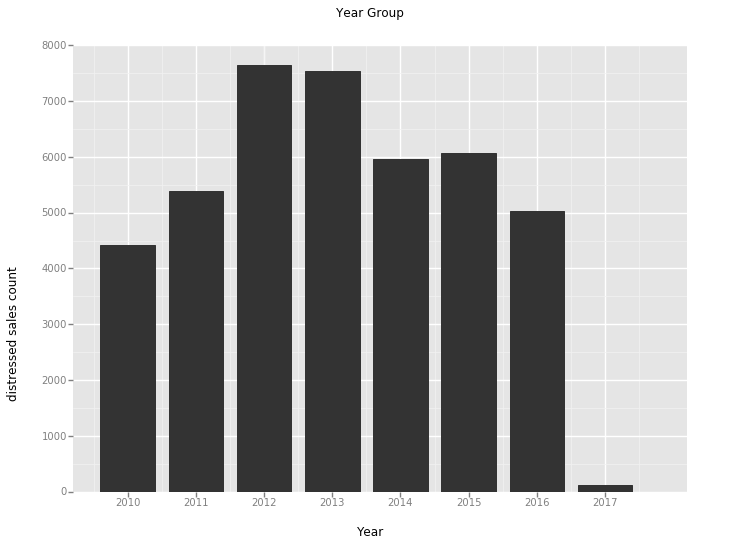

<ggplot: (308480485)>

In [11]:
Year_grouped = ggplot(aes(x = 'factor(txn_year)'), data = DF_Distressed_Transaction_data) + geom_bar() +\
labs(title = "Year Group") + xlab("Year") + ylab("distressed sales count")
Year_grouped

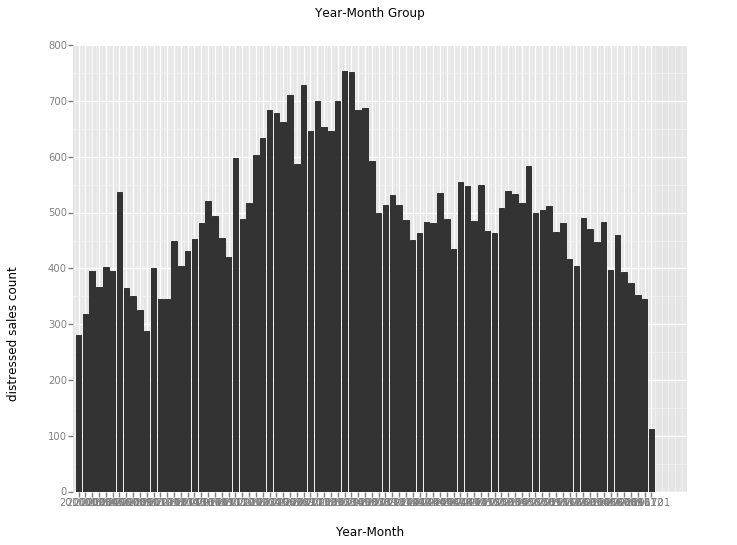

<ggplot: (305420893)>

In [12]:
Year_Month_grouped = ggplot(aes(x = 'factor(YearMonth)'), data = DF_Distressed_Transaction_data) + geom_bar() + \
labs(title = "Year-Month Group")+ xlab("Year-Month") + ylab("distressed sales count")
Year_Month_grouped

### Answer: The number of distressd sale increased from 2010 and peaked at 2012, then decreased. (From Year-Month grouped plot, we can also find some clue of seasonality movements.)

## How profit varies based on how long to be resold

In [13]:

# Join two transaction tables to get sale differences
SF_Resale_Data_raw = SF_Transaction_Data_raw[SF_Transaction_Data_raw['exit_txn_id'] <> None]
SF_Resale_Data_raw = SF_Resale_Data_raw.join\
(SF_Transaction_Data_raw, on = {'exit_txn_id':'txn_id'}, how = 'inner')
SF_Resale_Data_raw.rename({'txn_date.1': 'resale_date', 'txn_year.1': 'resale_year',\
                                       'txn_month.1':'resale_month', 'buyer_name.1':'resale_buyer_name', \
                                       'seller_name.1':'resale_seller_name', 'purchase_price.1': 'resale_price',\
                                       'loan_amt.1':'resale_loan_amt', 'lender_name.1': 'resale_lender_name',\
                                       'distress_indicator.1': 'resale_distress_indicator', \
                           'distress_indicator_flag.1': 'resale_distress_indicator_flag', 'exit_txn_id.1':'resale_exit_txn_id'})
SF_Resale_Data_raw = SF_Resale_Data_raw.join(SF_Property_Data, on = 'property_id', how = 'left')
total_resale_number = len(SF_Resale_Data_raw)
purchase_price_zero_number = (SF_Resale_Data_raw['purchase_price'] ==0).sum()
resale_price_zero_number = (SF_Resale_Data_raw['resale_price'] == 0).sum()

print 'There are %0.f resale transations, %.0f of them with 0 purchase price and %.0f of them with resale price equal to 0.' \
%(total_resale_number, purchase_price_zero_number, resale_price_zero_number)

#clean valid resale data
SF_Valid_Resale_Data =  SF_Resale_Data_raw[SF_Resale_Data_raw.apply(lambda x: x['purchase_price'] > 0 and x['resale_price'] > 0)]
SF_Invalid_Resale_Data = SF_Resale_Data_raw[SF_Resale_Data_raw.apply(lambda x: x['purchase_price']==0 or x['resale_price']==0)]
#We can explore "SF_Invalid_Resale_Data" dataset later (0 values can be approximated by loan_amt)



There are 1210 resale transations, 106 of them with 0 purchase price and 123 of them with resale price equal to 0.


In [14]:
SF_Valid_Resale_Data['resale_profit'] = SF_Valid_Resale_Data['resale_price'] - SF_Valid_Resale_Data['purchase_price']
SF_Valid_Resale_Data['profit_pct'] = SF_Valid_Resale_Data['resale_price'] / SF_Valid_Resale_Data['purchase_price'] - 1
SF_Valid_Resale_Data['resale_time_diff_months'] = (SF_Valid_Resale_Data['resale_year'] - SF_Valid_Resale_Data['txn_year']) * 12 + \
                                                (SF_Valid_Resale_Data['resale_month'] - SF_Valid_Resale_Data['txn_month'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130a20650>]], dtype=object)

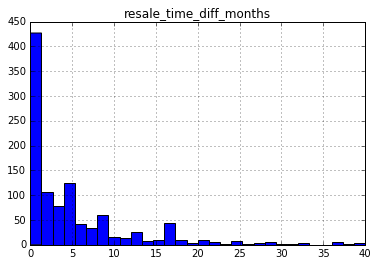

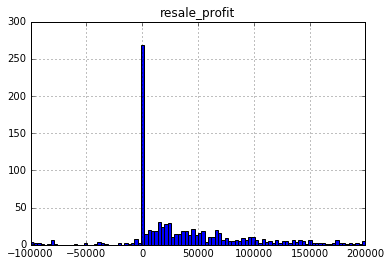

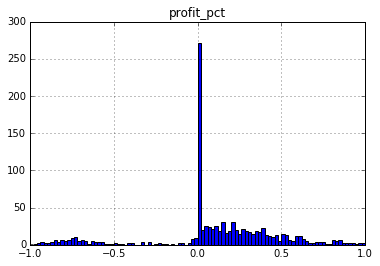

In [15]:

DF_Valid_Resale_Data = SF_Valid_Resale_Data.to_dataframe()

SF_Valid_Resale_Data['resale_profit'].show()
SF_Valid_Resale_Data['profit_pct'].show()
SF_Valid_Resale_Data['resale_time_diff_months'].show()
DF_Valid_Resale_Data.hist(column = 'resale_time_diff_months', color = 'blue', bins = 30, range = (0, 40))
DF_Valid_Resale_Data.hist(column = 'resale_profit', color = 'blue', bins = 100, range = (-100000,200000))

DF_Valid_Resale_Data.hist(column = 'profit_pct', color = 'blue', bins = 100, range = (-1,1))

In [16]:
profit_Vs_ResaleTime = ggplot(aes(x = 'resale_time_diff_months', y = 'profit_pct'), data = DF_Valid_Resale_Data) + geom_point() + \
scale_y_continuous(limits = (-2, 2))

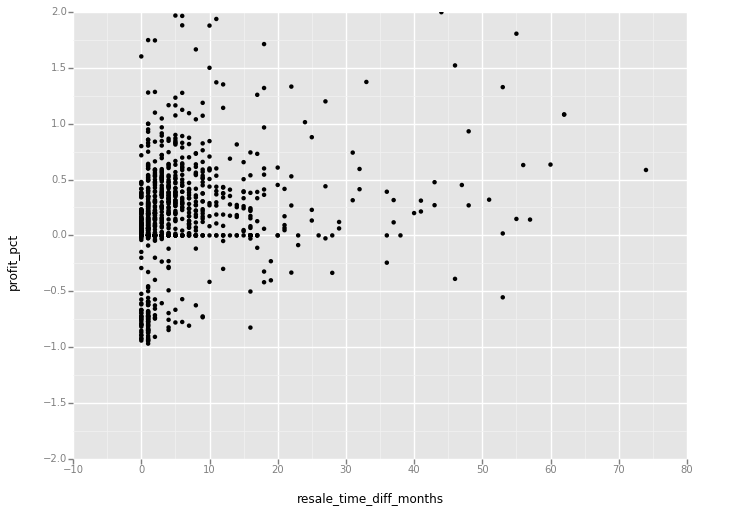

<ggplot: (318874109)>

In [17]:
profit_Vs_ResaleTime

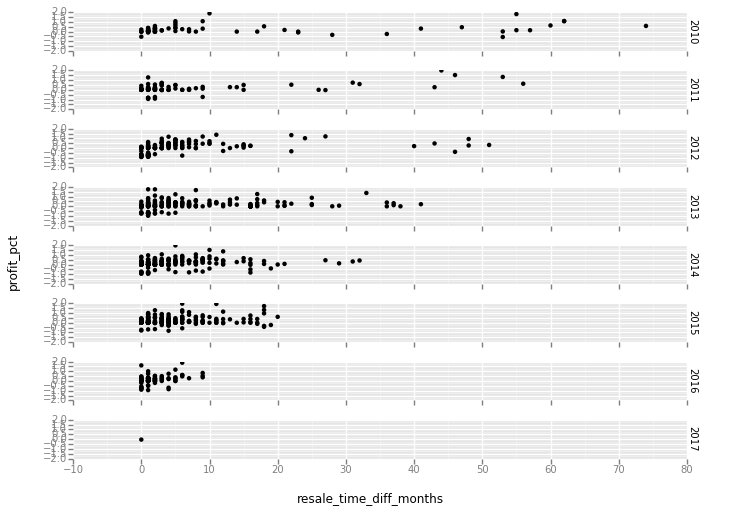

<ggplot: (318874109)>

In [18]:
plot_purchase_year = profit_Vs_ResaleTime + facet_grid('txn_year')
plot_purchase_year

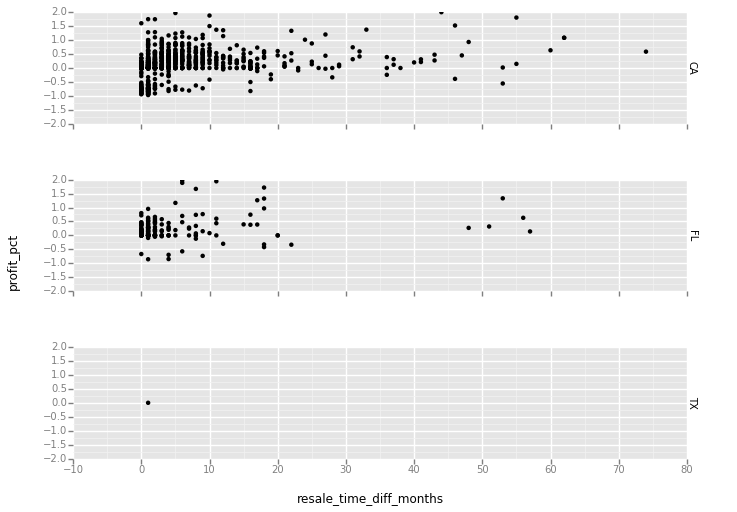

<ggplot: (318874109)>

In [19]:
profit_Vs_ResaleTime + facet_grid('property_state')

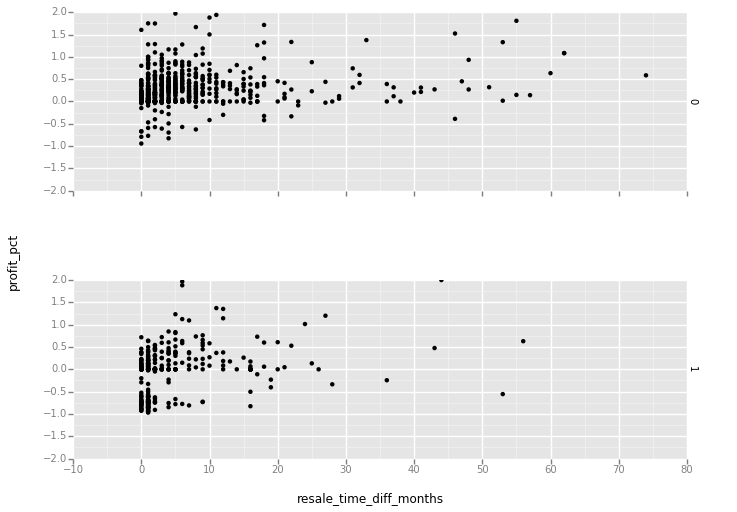

<ggplot: (318874109)>

In [20]:
profit_Vs_ResaleTime + facet_grid('resale_distress_indicator_flag')


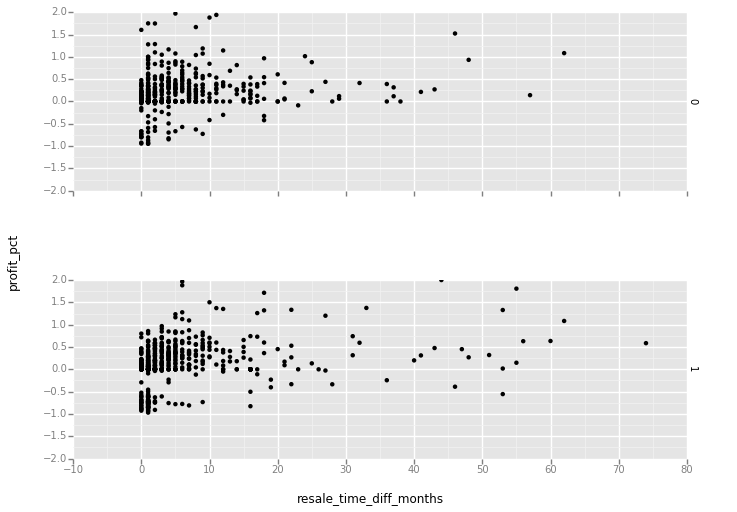

<ggplot: (318874109)>

In [21]:
profit_Vs_ResaleTime + facet_grid('distress_indicator_flag')

## Answer: from all above, profit percentage is positively correlated to how long to resale. I think it is partially because of the appreciation of property value through time. Also, we can see it actually depends on other factors.

# Questions Part 2: Modeling

## 1.Build model to predict the percent increase in home price from purchase to resale

In [22]:
import math
from math import pi
SF_All_Available_Data = SF_Valid_Resale_Data[SF_Valid_Resale_Data.apply(lambda x: (x['resale_time_diff_months'] <= 18) and \
                                                                    (x['resale_profit'] > 0))]
print 'There is %.0f data available' %len(SF_All_Available_Data)
SF_All_Available_Data['profit_pct'].show()


There is 609 data available


There are some outliers and it may affect our model, so I decided to delete them.

In [23]:
SF_All_Available_Data = SF_All_Available_Data[SF_All_Available_Data['profit_pct'] <= 3.5]



Explore hints of seasonalities, since it is common attribute for real estate data
* explore both purchase and resale 

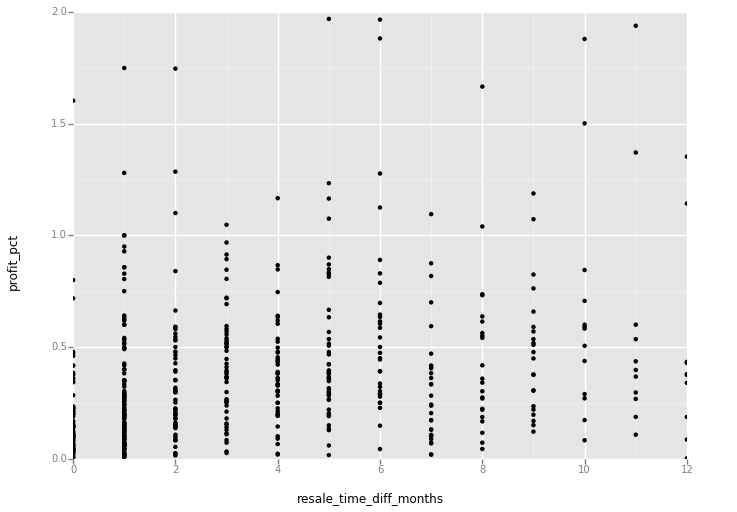

<ggplot: (319587625)>

In [24]:
DF_All_Available_Data = SF_All_Available_Data.to_dataframe()
p1 = ggplot(aes(x = 'resale_time_diff_months', y = 'profit_pct'), data = DF_All_Available_Data) + geom_point() + \
scale_y_continuous(limits=(0,2)) + scale_x_continuous(limits=(0,12)) 
p1


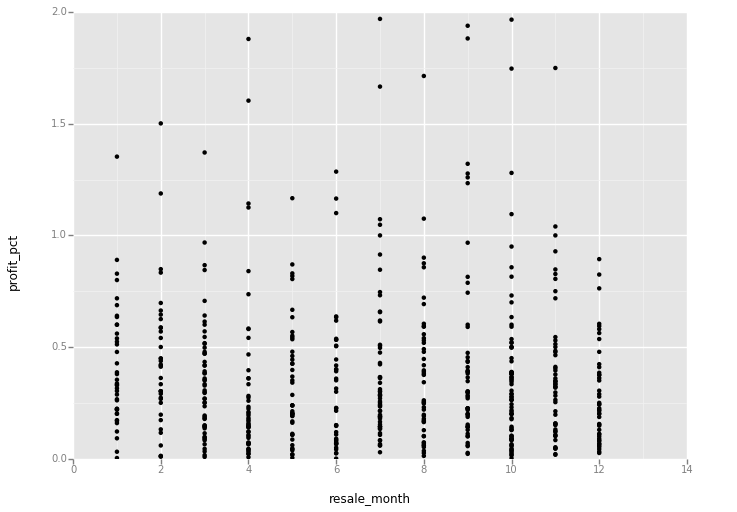

<ggplot: (317942817)>

In [25]:
p2 = ggplot(aes(x = 'resale_month', y = 'profit_pct'), data = DF_All_Available_Data) + geom_point() + scale_y_continuous(limits=(0,2))
p2

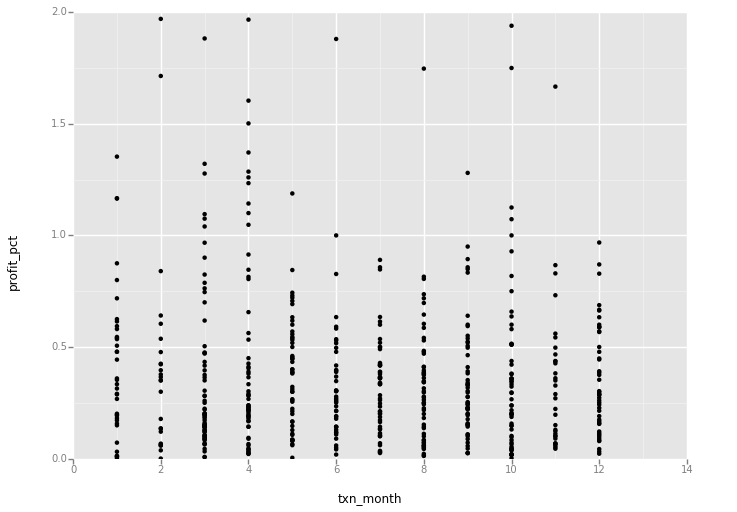

<ggplot: (319372533)>

In [26]:
p3 = ggplot(aes(x = 'txn_month', y = 'profit_pct'), data = DF_All_Available_Data) + geom_point() + scale_y_continuous(limits=(0,2))
p3

There are seasonalities in the data.

### Creating dumy variables for categorical variables

In [27]:
categorical_features = ['property_state', 'property_type',\
                       'construction_type', 'foundation_type']
for feature in categorical_features:
    transaction_one_hot_encoded = SF_All_Available_Data[feature].apply(lambda x: {x:1})
    transaction_unpacked = transaction_one_hot_encoded.unpack(column_name_prefix = feature)
    #change None's to 0's
    for column in transaction_unpacked.column_names():
        transaction_unpacked[column] = transaction_unpacked[column].fillna(0)
    
    SF_All_Available_Data.remove_column(feature)
    SF_All_Available_Data.add_columns(transaction_unpacked)
    

### Creating new features (property age/yrs, seasonality variables, rescale exsiting features)

In [28]:
#Seasonality variables captures both purchase time and resale time
SF_All_Available_Data['purchase_ssnlt_sin'] = SF_All_Available_Data['txn_month'].apply(lambda x: math.sin(2 * pi * x / 12))
SF_All_Available_Data['purchase_ssnlt_cos'] = SF_All_Available_Data['txn_month'].apply(lambda x: math.cos(2 * pi * x / 12))
SF_All_Available_Data['resale_ssnlt_sin'] = SF_All_Available_Data['txn_month'].apply(lambda x: math.sin(2 * pi * x / 12))
SF_All_Available_Data['resale_ssnlt_cos'] = SF_All_Available_Data['txn_month'].apply(lambda x: math.cos(2 * pi * x / 12))
#Scaling property_age by deviding 10 and sqft by 100
SF_All_Available_Data['property_age'] = (SF_All_Available_Data['resale_year'] - SF_All_Available_Data['yr_built'])/10
SF_All_Available_Data['rescale_sqft'] = SF_All_Available_Data['sqft'] / 100


### Preparing training, validation and testing dataset

In [29]:
training_validation_set, testing_set = SF_All_Available_Data.random_split(0.8, seed = 1)
training_validation_set = graphlab.toolkits.cross_validation.shuffle(training_validation_set, random_seed = 2)
print len(SF_All_Available_Data)
print len(training_validation_set)
print len(testing_set)

599
478
121


### 10-fold cross validation to select lasso penalty and features
* 1.starting with full set of features to find optimal lasso penalty
* 2.using optimal lass penalty to find train model and get selected features
* 3.using selected features to get model 
* 4.checking coefficients
* 5.checking testing error

In [30]:
def k_fold_cross_validation(k, l1_penalty, data, output_name, features_list):
    n = len(data)
    for i in xrange(k):
        start = i * n / k
        end = (i + 1) * n / k - 1
        validation = data[start:end+1]
        train = data[0:start].append(data[end+1:])
        model = graphlab.linear_regression.create(train, target = output_name, features= features_list,
                                                 l1_penalty = l1_penalty, l2_penalty = 0, max_iterations=100,\
                                                  validation_set = None)
        if i == 0:
            error = ((model.predict(validation) - validation[output_name])**2).sum()
        else:
            error += ((model.predict(validation) - validation[output_name])**2).sum()
    return error/k


Starting with full set of our features

In [31]:
model_features = ['rescale_sqft',
 'resale_time_diff_months',
 'purchase_ssnlt_sin',
 'purchase_ssnlt_cos',
 'resale_ssnlt_sin',
 'resale_ssnlt_cos',
 'property_age',
 'property_state.CA',
 'property_state.FL',
 'property_type.RAPT',
 'property_type.RCON',
 'property_type.RDUP',
 'property_type.RMFD',
 'property_type.RMOB',
 'property_type.RMSC',
 'property_type.RQUA',
 'property_type.RSFR',
 'property_type.RTRI',
 'property_type.VRES',
 'distress_indicator_flag',
 'resale_distress_indicator_flag',
 'construction_type.0',
 'construction_type.1',
 'construction_type.2',
 'construction_type.4',
 'foundation_type.2',
 'foundation_type.20',
 'foundation_type.22',
 'foundation_type.5',
 'foundation_type.8']
target = 'profit_pct'

Using 10-fold cross validation method to select optimal lasso penalty

In [32]:
k = 10
l1_penalties = np.array([0.1,0.5, 1,1.5,2,4,8, 16, 32, 50, 100, 300])
errors = np.empty(12)
i = 0
for penalty in l1_penalties:
    error = k_fold_cross_validation(k, penalty, training_validation_set, target, model_features)
    print 'when l1_penalty = %f, Error = %f' % (penalty, error)
    if penalty == l1_penalties[0]:
        min_penalty = penalty
        min_error = error
    elif min_error > error:
        min_error = error
        min_penalty = penalty
    errors[i] = error   
    i+=1

WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 1.046949     | 2.624629           | 0.490248      |

| 2         | 3        | 0.000134  | 1.052330     | 2.530586           | 0.473382      |

| 3         | 4        | 0.000134  | 1.057800     | 2.481472           | 0.468250      |

| 4         | 5        | 0.000134  | 1.062961     | 2.449119           | 0.464453      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042643     | 2.631460           | 0.499745      |

| 2         | 3        | 0.000134  | 0.049048     | 2.543118           | 0.482817      |

| 3         | 4        | 0.000134  | 0.054440     | 2.499939           | 0.477612      |

| 4         | 5        | 0.000134  | 0.059981     | 2.473242           | 0.473630      |

| 5         | 6        | 0.000134  | 0.065252     | 2.451533           | 0.470022      |

| 6         | 7        | 0.000134  | 0.070794     | 2.431243           | 0.466903      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044350     | 2.647445           | 0.482594      |

| 2         | 3        | 0.000134  | 0.049688     | 2.548833           | 0.466166      |

| 3         | 4        | 0.000134  | 0.055213     | 2.505757           | 0.461043      |

| 4         | 5        | 0.000134  | 0.060251     | 2.478827           | 0.457171      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042370     | 2.556899           | 0.453453      |

| 2         | 3        | 0.000134  | 0.047760     | 2.471078           | 0.437844      |

| 3         | 4        | 0.000134  | 0.053162     | 2.430360           | 0.433213      |

| 4         | 5        | 0.000134  | 0.058315     | 2.409452           | 0.429775      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.041560     | 2.646275           | 0.483676      |

| 2         | 3        | 0.000134  | 0.046781     | 2.543975           | 0.466889      |

| 3         | 4        | 0.000134  | 0.052031     | 2.500229           | 0.461483      |

| 4         | 5        | 0.000134  | 0.057257     | 2.472707           | 0.457373      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045430     | 2.646507           | 0.485482      |

| 2         | 3        | 0.000134  | 0.050563     | 2.539215           | 0.469093      |

| 3         | 4        | 0.000134  | 0.055886     | 2.494707           | 0.463803      |

| 4         | 5        | 0.000134  | 0.061125     | 2.466381           | 0.459709      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045741     | 2.634655           | 0.467319      |

| 2         | 3        | 0.000134  | 0.050945     | 2.561215           | 0.451479      |

| 3         | 4        | 0.000134  | 0.056140     | 2.525993           | 0.446891      |

| 4         | 5        | 0.000134  | 0.060952     | 2.506693           | 0.443554      |

| 5         | 6        | 0.000134  | 0.066011     | 2.491684           | 0.440631      |

| 6         | 7        | 0.000134  | 0.071182     | 2.477377           | 0.438178      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042784     | 2.650520           | 0.464897      |

| 2         | 3        | 0.000134  | 0.048251     | 2.560395           | 0.448752      |

| 3         | 4        | 0.000134  | 0.053529     | 2.520612           | 0.443880      |

| 4         | 5        | 0.000134  | 0.058833     | 2.497114           | 0.440300      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042775     | 2.645287           | 0.486938      |

| 2         | 3        | 0.000134  | 0.048622     | 2.537432           | 0.470734      |

| 3         | 4        | 0.000134  | 0.053913     | 2.489820           | 0.465550      |

| 4         | 5        | 0.000134  | 0.058921     | 2.458640           | 0.461640      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042445     | 2.634660           | 0.490093      |

| 2         | 3        | 0.000134  | 0.047548     | 2.543983           | 0.473578      |

| 3         | 4        | 0.000134  | 0.052936     | 2.500245           | 0.468372      |

| 4         | 5        | 0.000134  | 0.057563     | 2.472782           | 0.464412      |

| 5         | 6        | 0.000134  | 0.062789     | 2.450474           | 0.460904      |

| 6         | 7        | 0.000134  | 0.067596     | 2.429929           | 0.457958      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 0.100000, Error = 10.597108


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042950     | 2.625604           | 0.490356      |

| 2         | 3        | 0.000134  | 0.048233     | 2.530811           | 0.473412      |

| 3         | 4        | 0.000134  | 0.053561     | 2.481617           | 0.468250      |

| 4         | 5        | 0.000134  | 0.058761     | 2.449448           | 0.464462      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044140     | 2.632330           | 0.499852      |

| 2         | 3        | 0.000134  | 0.049180     | 2.543143           | 0.482852      |

| 3         | 4        | 0.000134  | 0.054393     | 2.499776           | 0.477621      |

| 4         | 5        | 0.000134  | 0.059605     | 2.473182           | 0.473649      |

| 5         | 6        | 0.000134  | 0.064806     | 2.451691           | 0.470053      |

| 6         | 7        | 0.000134  | 0.069911     | 2.431645           | 0.466943      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042455     | 2.648423           | 0.482702      |

| 2         | 3        | 0.000134  | 0.047663     | 2.549044           | 0.466198      |

| 3         | 4        | 0.000134  | 0.053032     | 2.505741           | 0.461048      |

| 4         | 5        | 0.000134  | 0.057745     | 2.478578           | 0.457181      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043161     | 2.557268           | 0.453558      |

| 2         | 3        | 0.000134  | 0.048476     | 2.471489           | 0.437870      |

| 3         | 4        | 0.000134  | 0.053813     | 2.430727           | 0.433207      |

| 4         | 5        | 0.000134  | 0.059000     | 2.409909           | 0.429778      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042295     | 2.647218           | 0.483783      |

| 2         | 3        | 0.000134  | 0.047501     | 2.544047           | 0.466924      |

| 3         | 4        | 0.000134  | 0.052789     | 2.500082           | 0.461492      |

| 4         | 5        | 0.000134  | 0.057961     | 2.472629           | 0.457390      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043072     | 2.647450           | 0.485586      |

| 2         | 3        | 0.000134  | 0.048677     | 2.539433           | 0.469121      |

| 3         | 4        | 0.000134  | 0.054012     | 2.494964           | 0.463812      |

| 4         | 5        | 0.000134  | 0.059255     | 2.466712           | 0.459730      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042212     | 2.635634           | 0.467422      |

| 2         | 3        | 0.000134  | 0.047140     | 2.561284           | 0.451508      |

| 3         | 4        | 0.000134  | 0.052396     | 2.525847           | 0.446892      |

| 4         | 5        | 0.000134  | 0.057717     | 2.506620           | 0.443564      |

| 5         | 6        | 0.000134  | 0.062903     | 2.491806           | 0.440652      |

| 6         | 7        | 0.000134  | 0.067904     | 2.477723           | 0.438206      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043023     | 2.651349           | 0.465004      |

| 2         | 3        | 0.000134  | 0.048068     | 2.560369           | 0.448781      |

| 3         | 4        | 0.000134  | 0.053185     | 2.520412           | 0.443884      |

| 4         | 5        | 0.000134  | 0.058509     | 2.497033           | 0.440316      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043290     | 2.646229           | 0.487044      |

| 2         | 3        | 0.000134  | 0.048572     | 2.537656           | 0.470766      |

| 3         | 4        | 0.000134  | 0.053861     | 2.490235           | 0.465563      |

| 4         | 5        | 0.000134  | 0.058927     | 2.459285           | 0.461663      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042950     | 2.635635           | 0.490200      |

| 2         | 3        | 0.000134  | 0.048208     | 2.544203           | 0.473609      |

| 3         | 4        | 0.000134  | 0.053400     | 2.500237           | 0.468376      |

| 4         | 5        | 0.000134  | 0.058746     | 2.472534           | 0.464422      |

| 5         | 6        | 0.000134  | 0.066271     | 2.450311           | 0.460930      |

| 6         | 7        | 0.000134  | 0.073108     | 2.430016           | 0.457992      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 0.500000, Error = 10.591625


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043801     | 2.626822           | 0.490492      |

| 2         | 3        | 0.000134  | 0.049047     | 2.531093           | 0.473452      |

| 3         | 4        | 0.000134  | 0.054382     | 2.481799           | 0.468251      |

| 4         | 5        | 0.000134  | 0.059781     | 2.449858           | 0.464475      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043130     | 2.633416           | 0.499986      |

| 2         | 3        | 0.000134  | 0.048386     | 2.543173           | 0.482898      |

| 3         | 4        | 0.000134  | 0.053477     | 2.499574           | 0.477635      |

| 4         | 5        | 0.000134  | 0.059041     | 2.473107           | 0.473677      |

| 5         | 6        | 0.000134  | 0.064421     | 2.451895           | 0.470097      |

| 6         | 7        | 0.000134  | 0.069927     | 2.432157           | 0.466999      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042561     | 2.649647           | 0.482838      |

| 2         | 3        | 0.000134  | 0.047817     | 2.549309           | 0.466239      |

| 3         | 4        | 0.000134  | 0.053086     | 2.505721           | 0.461056      |

| 4         | 5        | 0.000134  | 0.058262     | 2.478266           | 0.457196      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043496     | 2.557730           | 0.453690      |

| 2         | 3        | 0.000134  | 0.049093     | 2.472002           | 0.437906      |

| 3         | 4        | 0.000134  | 0.054371     | 2.431189           | 0.433203      |

| 4         | 5        | 0.000134  | 0.059626     | 2.410484           | 0.429786      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042817     | 2.648366           | 0.483920      |

| 2         | 3        | 0.000134  | 0.048141     | 2.544115           | 0.466970      |

| 3         | 4        | 0.000134  | 0.053650     | 2.499884           | 0.461505      |

| 4         | 5        | 0.000134  | 0.058576     | 2.472523           | 0.457416      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042909     | 2.648628           | 0.485716      |

| 2         | 3        | 0.000134  | 0.048154     | 2.539706           | 0.469157      |

| 3         | 4        | 0.000134  | 0.052994     | 2.495285           | 0.463825      |

| 4         | 5        | 0.000134  | 0.058518     | 2.467125           | 0.459759      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042355     | 2.636857           | 0.467552      |

| 2         | 3        | 0.000134  | 0.047306     | 2.561371           | 0.451546      |

| 3         | 4        | 0.000134  | 0.052611     | 2.525663           | 0.446896      |

| 4         | 5        | 0.000134  | 0.057769     | 2.506528           | 0.443579      |

| 5         | 6        | 0.000134  | 0.062794     | 2.491960           | 0.440681      |

| 6         | 7        | 0.000134  | 0.068178     | 2.478156           | 0.438246      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042239     | 2.652385           | 0.465138      |

| 2         | 3        | 0.000134  | 0.047420     | 2.560336           | 0.448821      |

| 3         | 4        | 0.000134  | 0.052467     | 2.520166           | 0.443894      |

| 4         | 5        | 0.000134  | 0.057853     | 2.496935           | 0.440342      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043861     | 2.647407           | 0.487178      |

| 2         | 3        | 0.000134  | 0.048996     | 2.537936           | 0.470807      |

| 3         | 4        | 0.000134  | 0.054066     | 2.490753           | 0.465581      |

| 4         | 5        | 0.000134  | 0.059099     | 2.460092           | 0.461696      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042370     | 2.636853           | 0.490335      |

| 2         | 3        | 0.000134  | 0.047094     | 2.544479           | 0.473651      |

| 3         | 4        | 0.000134  | 0.052384     | 2.500225           | 0.468384      |

| 4         | 5        | 0.000134  | 0.057692     | 2.472224           | 0.464437      |

| 5         | 6        | 0.000134  | 0.062809     | 2.450109           | 0.460965      |

| 6         | 7        | 0.000134  | 0.068381     | 2.430128           | 0.458041      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 1.000000, Error = 10.584926


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.041559     | 2.628040           | 0.490629      |

| 2         | 3        | 0.000134  | 0.046960     | 2.531375           | 0.473493      |

| 3         | 4        | 0.000134  | 0.051967     | 2.481981           | 0.468256      |

| 4         | 5        | 0.000134  | 0.057407     | 2.450269           | 0.464491      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042680     | 2.634503           | 0.500121      |

| 2         | 3        | 0.000134  | 0.047789     | 2.543203           | 0.482945      |

| 3         | 4        | 0.000134  | 0.052873     | 2.499371           | 0.477652      |

| 4         | 5        | 0.000134  | 0.056999     | 2.473032           | 0.473707      |

| 5         | 6        | 0.000134  | 0.062329     | 2.452097           | 0.470144      |

| 6         | 7        | 0.000134  | 0.067480     | 2.432666           | 0.467060      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042825     | 2.650870           | 0.482975      |

| 2         | 3        | 0.000134  | 0.047810     | 2.549573           | 0.466282      |

| 3         | 4        | 0.000134  | 0.053408     | 2.505701           | 0.461067      |

| 4         | 5        | 0.000134  | 0.058857     | 2.477959           | 0.457217      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.054553     | 2.558191           | 0.453822      |

| 2         | 3        | 0.000134  | 0.059839     | 2.472515           | 0.437943      |

| 3         | 4        | 0.000134  | 0.065462     | 2.431652           | 0.433201      |

| 4         | 5        | 0.000134  | 0.071171     | 2.411059           | 0.429797      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.041592     | 2.649453           | 0.484058      |

| 2         | 3        | 0.000134  | 0.047052     | 2.544140           | 0.467019      |

| 3         | 4        | 0.000134  | 0.052829     | 2.499658           | 0.461523      |

| 4         | 5        | 0.000134  | 0.058540     | 2.472406           | 0.457448      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044080     | 2.649806           | 0.485848      |

| 2         | 3        | 0.000134  | 0.049238     | 2.539870           | 0.469195      |

| 3         | 4        | 0.000134  | 0.054786     | 2.495505           | 0.463840      |

| 4         | 5        | 0.000134  | 0.060943     | 2.467468           | 0.459792      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043199     | 2.638080           | 0.467682      |

| 2         | 3        | 0.000134  | 0.048976     | 2.561458           | 0.451586      |

| 3         | 4        | 0.000134  | 0.054520     | 2.525480           | 0.446903      |

| 4         | 5        | 0.000134  | 0.060059     | 2.506439           | 0.443597      |

| 5         | 6        | 0.000134  | 0.064934     | 2.492116           | 0.440714      |

| 6         | 7        | 0.000134  | 0.070180     | 2.478593           | 0.438291      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044457     | 2.653421           | 0.465274      |

| 2         | 3        | 0.000134  | 0.049997     | 2.560304           | 0.448868      |

| 3         | 4        | 0.000134  | 0.055294     | 2.519924           | 0.443911      |

| 4         | 5        | 0.000134  | 0.060622     | 2.496842           | 0.440375      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042953     | 2.648585           | 0.487313      |

| 2         | 3        | 0.000134  | 0.048195     | 2.538216           | 0.470852      |

| 3         | 4        | 0.000134  | 0.053475     | 2.491278           | 0.465607      |

| 4         | 5        | 0.000134  | 0.059047     | 2.460918           | 0.461742      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.041734     | 2.638072           | 0.490470      |

| 2         | 3        | 0.000134  | 0.047268     | 2.544754           | 0.473693      |

| 3         | 4        | 0.000134  | 0.052742     | 2.500214           | 0.468396      |

| 4         | 5        | 0.000134  | 0.058008     | 2.471922           | 0.464459      |

| 5         | 6        | 0.000134  | 0.062913     | 2.449925           | 0.461008      |

| 6         | 7        | 0.000134  | 0.068120     | 2.430260           | 0.458096      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 1.500000, Error = 10.578255


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043465     | 2.629258           | 0.490767      |

| 2         | 3        | 0.000134  | 0.049209     | 2.531656           | 0.473536      |

| 3         | 4        | 0.000134  | 0.054517     | 2.482163           | 0.468262      |

| 4         | 5        | 0.000134  | 0.059368     | 2.450680           | 0.464510      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044136     | 2.635590           | 0.500256      |

| 2         | 3        | 0.000134  | 0.049538     | 2.543234           | 0.482994      |

| 3         | 4        | 0.000134  | 0.054580     | 2.499168           | 0.477670      |

| 4         | 5        | 0.000134  | 0.060311     | 2.472956           | 0.473740      |

| 5         | 6        | 0.000134  | 0.065708     | 2.452298           | 0.470194      |

| 6         | 7        | 0.000134  | 0.070982     | 2.433174           | 0.467125      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043081     | 2.652093           | 0.483113      |

| 2         | 3        | 0.000134  | 0.048754     | 2.549837           | 0.466327      |

| 3         | 4        | 0.000134  | 0.054227     | 2.505681           | 0.461082      |

| 4         | 5        | 0.000134  | 0.059748     | 2.477658           | 0.457243      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044348     | 2.558653           | 0.453956      |

| 2         | 3        | 0.000134  | 0.049704     | 2.473028           | 0.437983      |

| 3         | 4        | 0.000134  | 0.055355     | 2.432114           | 0.433202      |

| 4         | 5        | 0.000134  | 0.060456     | 2.411634           | 0.429811      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043262     | 2.650540           | 0.484197      |

| 2         | 3        | 0.000134  | 0.048644     | 2.544165           | 0.467070      |

| 3         | 4        | 0.000134  | 0.054189     | 2.499432           | 0.461545      |

| 4         | 5        | 0.000134  | 0.059765     | 2.472296           | 0.457483      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044550     | 2.650984           | 0.485981      |

| 2         | 3        | 0.000134  | 0.050233     | 2.539983           | 0.469235      |

| 3         | 4        | 0.000134  | 0.056379     | 2.495680           | 0.463861      |

| 4         | 5        | 0.000134  | 0.061860     | 2.467791           | 0.459832      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043157     | 2.639303           | 0.467814      |

| 2         | 3        | 0.000134  | 0.048447     | 2.561545           | 0.451628      |

| 3         | 4        | 0.000134  | 0.053669     | 2.525297           | 0.446915      |

| 4         | 5        | 0.000134  | 0.058525     | 2.506356           | 0.443621      |

| 5         | 6        | 0.000134  | 0.063918     | 2.492283           | 0.440754      |

| 6         | 7        | 0.000134  | 0.068922     | 2.479041           | 0.438344      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042427     | 2.654457           | 0.465410      |

| 2         | 3        | 0.000134  | 0.047769     | 2.560272           | 0.448917      |

| 3         | 4        | 0.000134  | 0.053083     | 2.519682           | 0.443933      |

| 4         | 5        | 0.000134  | 0.058144     | 2.496756           | 0.440414      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042557     | 2.649762           | 0.487448      |

| 2         | 3        | 0.000134  | 0.047763     | 2.538496           | 0.470900      |

| 3         | 4        | 0.000134  | 0.053191     | 2.491806           | 0.465637      |

| 4         | 5        | 0.000134  | 0.058467     | 2.461754           | 0.461797      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045611     | 2.639291           | 0.490606      |

| 2         | 3        | 0.000134  | 0.050791     | 2.545029           | 0.473738      |

| 3         | 4        | 0.000134  | 0.056376     | 2.500202           | 0.468411      |

| 4         | 5        | 0.000134  | 0.061900     | 2.471623           | 0.464485      |

| 5         | 6        | 0.000134  | 0.066932     | 2.449746           | 0.461054      |

| 6         | 7        | 0.000134  | 0.072815     | 2.430410           | 0.458157      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 2.000000, Error = 10.571843


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043846     | 2.634130           | 0.491327      |

| 2         | 3        | 0.000134  | 0.049336     | 2.532783           | 0.473732      |

| 3         | 4        | 0.000134  | 0.055200     | 2.483017           | 0.468323      |

| 4         | 5        | 0.000134  | 0.060782     | 2.452477           | 0.464627      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043218     | 2.639936           | 0.500808      |

| 2         | 3        | 0.000134  | 0.048557     | 2.543355           | 0.483210      |

| 3         | 4        | 0.000134  | 0.053894     | 2.498371           | 0.477774      |

| 4         | 5        | 0.000134  | 0.059444     | 2.472676           | 0.473902      |

| 5         | 6        | 0.000134  | 0.064467     | 2.453124           | 0.470437      |

| 6         | 7        | 0.000134  | 0.069798     | 2.435226           | 0.467437      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.058532     | 2.656987           | 0.483673      |

| 2         | 3        | 0.000134  | 0.064410     | 2.550355           | 0.466531      |

| 3         | 4        | 0.000134  | 0.069841     | 2.505122           | 0.461173      |

| 4         | 5        | 0.000134  | 0.075237     | 2.476134           | 0.457378      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043580     | 2.560499           | 0.454500      |

| 2         | 3        | 0.000134  | 0.048785     | 2.475082           | 0.438158      |

| 3         | 4        | 0.000134  | 0.054141     | 2.434102           | 0.433247      |

| 4         | 5        | 0.000134  | 0.059392     | 2.414154           | 0.429919      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.041711     | 2.654890           | 0.484763      |

| 2         | 3        | 0.000134  | 0.046990     | 2.544264           | 0.467294      |

| 3         | 4        | 0.000134  | 0.052277     | 2.498535           | 0.461659      |

| 4         | 5        | 0.000134  | 0.057660     | 2.471867           | 0.457654      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045396     | 2.655619           | 0.486521      |

| 2         | 3        | 0.000134  | 0.051142     | 2.540558           | 0.469426      |

| 3         | 4        | 0.000134  | 0.056627     | 2.496737           | 0.463975      |

| 4         | 5        | 0.000134  | 0.062245     | 2.469696           | 0.460017      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043219     | 2.643974           | 0.468359      |

| 2         | 3        | 0.000134  | 0.048434     | 2.561740           | 0.451822      |

| 3         | 4        | 0.000134  | 0.053787     | 2.524466           | 0.446998      |

| 4         | 5        | 0.000134  | 0.059226     | 2.506009           | 0.443754      |

| 5         | 6        | 0.000134  | 0.064628     | 2.492978           | 0.440957      |

| 6         | 7        | 0.000134  | 0.069930     | 2.480930           | 0.438611      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.056899     | 2.658601           | 0.465965      |

| 2         | 3        | 0.000134  | 0.062342     | 2.560142           | 0.449129      |

| 3         | 4        | 0.000134  | 0.068198     | 2.519341           | 0.444061      |

| 4         | 5        | 0.000134  | 0.074238     | 2.497164           | 0.440615      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045072     | 2.654474           | 0.487999      |

| 2         | 3        | 0.000134  | 0.050509     | 2.541881           | 0.471115      |

| 3         | 4        | 0.000134  | 0.055937     | 2.493927           | 0.465786      |

| 4         | 5        | 0.000134  | 0.061544     | 2.465109           | 0.462040      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044303     | 2.644166           | 0.491161      |

| 2         | 3        | 0.000134  | 0.049777     | 2.545522           | 0.473950      |

| 3         | 4        | 0.000134  | 0.055395     | 2.499638           | 0.468514      |

| 4         | 5        | 0.000134  | 0.061219     | 2.470346           | 0.464649      |

| 5         | 6        | 0.000134  | 0.067073     | 2.449266           | 0.461310      |

| 6         | 7        | 0.000134  | 0.072916     | 2.431415           | 0.458480      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 4.000000, Error = 10.548920


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044018     | 2.643874           | 0.492488      |

| 2         | 3        | 0.000134  | 0.049402     | 2.534939           | 0.474248      |

| 3         | 4        | 0.000134  | 0.055127     | 2.487176           | 0.468670      |

| 4         | 5        | 0.000134  | 0.060768     | 2.458710           | 0.465094      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045230     | 2.648630           | 0.501958      |

| 2         | 3        | 0.000134  | 0.051204     | 2.544291           | 0.483756      |

| 3         | 4        | 0.000134  | 0.057030     | 2.497927           | 0.478140      |

| 4         | 5        | 0.000134  | 0.062757     | 2.473567           | 0.474399      |

| 5         | 6        | 0.000134  | 0.068355     | 2.456490           | 0.471137      |

| 6         | 7        | 0.000134  | 0.073877     | 2.441632           | 0.468318      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044425     | 2.666626           | 0.484837      |

| 2         | 3        | 0.000134  | 0.050409     | 2.557090           | 0.467067      |

| 3         | 4        | 0.000134  | 0.055897     | 2.504662           | 0.461519      |

| 4         | 5        | 0.000134  | 0.061341     | 2.478196           | 0.457853      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043531     | 2.564191           | 0.455634      |

| 2         | 3        | 0.000134  | 0.049143     | 2.479188           | 0.438606      |

| 3         | 4        | 0.000134  | 0.054540     | 2.439740           | 0.433552      |

| 4         | 5        | 0.000134  | 0.060003     | 2.420539           | 0.430369      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.050180     | 2.663588           | 0.485936      |

| 2         | 3        | 0.000134  | 0.055828     | 2.552520           | 0.467857      |

| 3         | 4        | 0.000134  | 0.061117     | 2.499371           | 0.462089      |

| 4         | 5        | 0.000134  | 0.066194     | 2.474117           | 0.458230      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.054898     | 2.664313           | 0.487643      |

| 2         | 3        | 0.000134  | 0.060424     | 2.553663           | 0.469921      |

| 3         | 4        | 0.000134  | 0.065741     | 2.499189           | 0.464339      |

| 4         | 5        | 0.000134  | 0.071180     | 2.474264           | 0.460540      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044854     | 2.653034           | 0.469505      |

| 2         | 3        | 0.000134  | 0.051140     | 2.561935           | 0.452338      |

| 3         | 4        | 0.000134  | 0.056694     | 2.525507           | 0.447365      |

| 4         | 5        | 0.000134  | 0.062095     | 2.508618           | 0.444246      |

| 5         | 6        | 0.000134  | 0.067652     | 2.497336           | 0.441618      |

| 6         | 7        | 0.000134  | 0.073078     | 2.486878           | 0.439417      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044154     | 2.666890           | 0.467120      |

| 2         | 3        | 0.000134  | 0.049586     | 2.559883           | 0.449680      |

| 3         | 4        | 0.000134  | 0.057289     | 2.520680           | 0.444513      |

| 4         | 5        | 0.000134  | 0.062999     | 2.500474           | 0.441239      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.047625     | 2.663896           | 0.489145      |

| 2         | 3        | 0.000134  | 0.053098     | 2.556146           | 0.471649      |

| 3         | 4        | 0.000134  | 0.058995     | 2.499312           | 0.466218      |

| 4         | 5        | 0.000134  | 0.064513     | 2.470609           | 0.462656      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045197     | 2.653579           | 0.492313      |

| 2         | 3        | 0.000134  | 0.050763     | 2.546482           | 0.474493      |

| 3         | 4        | 0.000134  | 0.056348     | 2.499494           | 0.468874      |

| 4         | 5        | 0.000134  | 0.061415     | 2.473227           | 0.465181      |

| 5         | 6        | 0.000134  | 0.066853     | 2.455355           | 0.462047      |

| 6         | 7        | 0.000134  | 0.071669     | 2.439908           | 0.459398      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 8.000000, Error = 10.516696


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044905     | 2.662236           | 0.494948      |

| 2         | 3        | 0.000134  | 0.049972     | 2.550951           | 0.475530      |

| 3         | 4        | 0.000134  | 0.055337     | 2.493577           | 0.469639      |

| 4         | 5        | 0.000134  | 0.060917     | 2.468771           | 0.466365      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.047871     | 2.666017           | 0.504431      |

| 2         | 3        | 0.000134  | 0.053555     | 2.559480           | 0.485111      |

| 3         | 4        | 0.000134  | 0.059129     | 2.504773           | 0.479222      |

| 4         | 5        | 0.000134  | 0.064579     | 2.483265           | 0.475813      |

| 5         | 6        | 0.000134  | 0.070024     | 2.468950           | 0.473026      |

| 6         | 7        | 0.000134  | 0.075628     | 2.456462           | 0.470625      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045183     | 2.684756           | 0.487352      |

| 2         | 3        | 0.000134  | 0.050918     | 2.584697           | 0.468479      |

| 3         | 4        | 0.000134  | 0.056474     | 2.536652           | 0.462590      |

| 4         | 5        | 0.000134  | 0.061982     | 2.508138           | 0.459162      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.046301     | 2.571576           | 0.458114      |

| 2         | 3        | 0.000134  | 0.052056     | 2.486571           | 0.439879      |

| 3         | 4        | 0.000134  | 0.057371     | 2.446498           | 0.434458      |

| 4         | 5        | 0.000134  | 0.062915     | 2.426994           | 0.431512      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044303     | 2.680986           | 0.488460      |

| 2         | 3        | 0.000134  | 0.049786     | 2.578722           | 0.469285      |

| 3         | 4        | 0.000134  | 0.055395     | 2.522722           | 0.463240      |

| 4         | 5        | 0.000134  | 0.060891     | 2.490703           | 0.459667      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045004     | 2.681701           | 0.490068      |

| 2         | 3        | 0.000134  | 0.050537     | 2.575378           | 0.471311      |

| 3         | 4        | 0.000134  | 0.056066     | 2.519020           | 0.465464      |

| 4         | 5        | 0.000134  | 0.061629     | 2.486279           | 0.461954      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043859     | 2.671153           | 0.471982      |

| 2         | 3        | 0.000134  | 0.049966     | 2.563637           | 0.453680      |

| 3         | 4        | 0.000134  | 0.055846     | 2.529808           | 0.448411      |

| 4         | 5        | 0.000134  | 0.062459     | 2.513875           | 0.445569      |

| 5         | 6        | 0.000134  | 0.068517     | 2.503527           | 0.443320      |

| 6         | 7        | 0.000134  | 0.074267     | 2.494972           | 0.441383      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044283     | 2.684542           | 0.469578      |

| 2         | 3        | 0.000134  | 0.049955     | 2.573702           | 0.451071      |

| 3         | 4        | 0.000134  | 0.055503     | 2.526380           | 0.445663      |

| 4         | 5        | 0.000134  | 0.060993     | 2.507870           | 0.442709      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.042781     | 2.682741           | 0.491635      |

| 2         | 3        | 0.000134  | 0.048134     | 2.578898           | 0.473133      |

| 3         | 4        | 0.000134  | 0.053555     | 2.524084           | 0.467521      |

| 4         | 5        | 0.000134  | 0.058852     | 2.493684           | 0.464324      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044082     | 2.671620           | 0.494798      |

| 2         | 3        | 0.000134  | 0.049174     | 2.560647           | 0.475885      |

| 3         | 4        | 0.000134  | 0.054476     | 2.503668           | 0.469946      |

| 4         | 5        | 0.000134  | 0.059913     | 2.479743           | 0.466501      |

| 5         | 6        | 0.000134  | 0.065336     | 2.462530           | 0.463776      |

| 6         | 7        | 0.000134  | 0.070491     | 2.447555           | 0.461462      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 16.000000, Error = 10.477231


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045389     | 2.698295           | 0.500376      |

| 2         | 3        | 0.000134  | 0.050817     | 2.597020           | 0.479151      |

| 3         | 4        | 0.000134  | 0.056066     | 2.546738           | 0.472544      |

| 4         | 5        | 0.000134  | 0.061435     | 2.521508           | 0.469311      |

| 5         | 6        | 0.000134  | 0.076711     | 2.505108           | 0.467118      |

| 6         | 7        | 0.000134  | 0.082455     | 2.495401           | 0.465490      |

| 11        | 12       | 0.000134  | 0.109621     | 2.485894           | 0.460896      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043740     | 2.700791           | 0.509937      |

| 2         | 3        | 0.000134  | 0.049286     | 2.606489           | 0.488861      |

| 3         | 4        | 0.000134  | 0.055108     | 2.561425           | 0.482290      |

| 4         | 5        | 0.000134  | 0.060850     | 2.541453           | 0.478954      |

| 5         | 6        | 0.000134  | 0.066642     | 2.530144           | 0.476402      |

| 6         | 7        | 0.000134  | 0.072305     | 2.523353           | 0.474256      |

| 11        | 12       | 0.000134  | 0.099173     | 2.468096           | 0.468348      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044335     | 2.721017           | 0.492931      |

| 2         | 3        | 0.000134  | 0.049940     | 2.635435           | 0.472353      |

| 3         | 4        | 0.000134  | 0.055883     | 2.597565           | 0.465713      |

| 4         | 5        | 0.000134  | 0.061605     | 2.583910           | 0.462423      |

| 5         | 6        | 0.000134  | 0.067150     | 2.578654           | 0.459888      |

| 6         | 7        | 0.000134  | 0.072663     | 2.566365           | 0.457915      |

| 11        | 12       | 0.000134  | 0.099911     | 2.509666           | 0.452253      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044678     | 2.583329           | 0.463584      |

| 2         | 3        | 0.000134  | 0.050185     | 2.517353           | 0.443524      |

| 3         | 4        | 0.000134  | 0.055631     | 2.502801           | 0.437274      |

| 4         | 5        | 0.000134  | 0.061110     | 2.493854           | 0.434124      |

| 5         | 6        | 0.000134  | 0.066658     | 2.484500           | 0.432030      |

| 6         | 7        | 0.000134  | 0.072196     | 2.480443           | 0.430467      |

| 11        | 12       | 0.000134  | 0.099443     | 2.485315           | 0.425437      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043077     | 2.715536           | 0.494056      |

| 2         | 3        | 0.000134  | 0.048695     | 2.622410           | 0.473195      |

| 3         | 4        | 0.000134  | 0.053960     | 2.579752           | 0.466546      |

| 4         | 5        | 0.000134  | 0.058775     | 2.560874           | 0.463225      |

| 5         | 6        | 0.000134  | 0.064094     | 2.549538           | 0.460622      |

| 6         | 7        | 0.000134  | 0.069549     | 2.545675           | 0.458694      |

| 11        | 12       | 0.000134  | 0.095854     | 2.511927           | 0.452860      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.046113     | 2.712880           | 0.495466      |

| 2         | 3        | 0.000134  | 0.051862     | 2.619297           | 0.475069      |

| 3         | 4        | 0.000134  | 0.056837     | 2.576068           | 0.468617      |

| 4         | 5        | 0.000134  | 0.062447     | 2.556061           | 0.465311      |

| 5         | 6        | 0.000134  | 0.068467     | 2.543497           | 0.462574      |

| 6         | 7        | 0.000134  | 0.074056     | 2.537003           | 0.460435      |

| 11        | 12       | 0.000134  | 0.101343     | 2.509474           | 0.455371      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044301     | 2.706720           | 0.477477      |

| 2         | 3        | 0.000134  | 0.049979     | 2.604749           | 0.457340      |

| 3         | 4        | 0.000134  | 0.055819     | 2.551563           | 0.451242      |

| 4         | 5        | 0.000134  | 0.061368     | 2.527556           | 0.448246      |

| 5         | 6        | 0.000134  | 0.066723     | 2.518437           | 0.446072      |

| 6         | 7        | 0.000134  | 0.072295     | 2.513997           | 0.444458      |

| 11        | 12       | 0.000134  | 0.102130     | 2.520396           | 0.440259      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043381     | 2.719096           | 0.475056      |

| 2         | 3        | 0.000134  | 0.048799     | 2.620266           | 0.454815      |

| 3         | 4        | 0.000134  | 0.054215     | 2.568929           | 0.448611      |

| 4         | 5        | 0.000134  | 0.059465     | 2.540822           | 0.445804      |

| 5         | 6        | 0.000134  | 0.065129     | 2.519606           | 0.443602      |

| 6         | 7        | 0.000134  | 0.070729     | 2.503011           | 0.441691      |

| 11        | 12       | 0.000134  | 0.099668     | 2.483749           | 0.436199      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044601     | 2.715680           | 0.497106      |

| 2         | 3        | 0.000134  | 0.050272     | 2.622701           | 0.477028      |

| 3         | 4        | 0.000134  | 0.055709     | 2.580132           | 0.470947      |

| 4         | 5        | 0.000134  | 0.061148     | 2.561454           | 0.468174      |

| 5         | 6        | 0.000134  | 0.066546     | 2.550063           | 0.466095      |

| 6         | 7        | 0.000134  | 0.071554     | 2.541175           | 0.464177      |

| 11        | 12       | 0.000134  | 0.097791     | 2.508048           | 0.459029      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045225     | 2.707702           | 0.500321      |

| 2         | 3        | 0.000134  | 0.050771     | 2.610087           | 0.479667      |

| 3         | 4        | 0.000134  | 0.056564     | 2.560719           | 0.473126      |

| 4         | 5        | 0.000134  | 0.062605     | 2.535654           | 0.469801      |

| 5         | 6        | 0.000134  | 0.068658     | 2.519240           | 0.467265      |

| 6         | 7        | 0.000134  | 0.074625     | 2.506994           | 0.465130      |

| 11        | 12       | 0.000134  | 0.102547     | 2.506803           | 0.459445      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 32.000000, Error = 10.035385


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044765     | 2.733309           | 0.507167      |

| 2         | 3        | 0.000134  | 0.050032     | 2.649214           | 0.484281      |

| 3         | 4        | 0.000134  | 0.055452     | 2.616115           | 0.476733      |

| 4         | 5        | 0.000134  | 0.060800     | 2.601369           | 0.473519      |

| 5         | 6        | 0.000134  | 0.066580     | 2.583810           | 0.471707      |

| 6         | 7        | 0.000134  | 0.072286     | 2.570872           | 0.470461      |

| 11        | 12       | 0.000134  | 0.101484     | 2.527987           | 0.465146      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045371     | 2.736719           | 0.516829      |

| 2         | 3        | 0.000134  | 0.051312     | 2.655891           | 0.494161      |

| 3         | 4        | 0.000134  | 0.057436     | 2.618653           | 0.486409      |

| 4         | 5        | 0.000134  | 0.064658     | 2.589139           | 0.482864      |

| 5         | 6        | 0.000134  | 0.070297     | 2.567758           | 0.480436      |

| 6         | 7        | 0.000134  | 0.075912     | 2.551633           | 0.478576      |

| 11        | 12       | 0.000134  | 0.103203     | 2.521685           | 0.473261      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044961     | 2.758241           | 0.499845      |

| 2         | 3        | 0.000134  | 0.050827     | 2.686715           | 0.477706      |

| 3         | 4        | 0.000134  | 0.056591     | 2.640378           | 0.469789      |

| 4         | 5        | 0.000134  | 0.062474     | 2.614136           | 0.466186      |

| 5         | 6        | 0.000134  | 0.068408     | 2.596790           | 0.464027      |

| 6         | 7        | 0.000134  | 0.074595     | 2.584036           | 0.462632      |

| 11        | 12       | 0.000134  | 0.106941     | 2.533727           | 0.456384      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.046231     | 2.623683           | 0.470329      |

| 2         | 3        | 0.000134  | 0.052016     | 2.572478           | 0.448639      |

| 3         | 4        | 0.000134  | 0.057555     | 2.545353           | 0.440937      |

| 4         | 5        | 0.000134  | 0.062687     | 2.537864           | 0.437545      |

| 5         | 6        | 0.000134  | 0.078632     | 2.539458           | 0.435548      |

| 6         | 7        | 0.000134  | 0.084151     | 2.544957           | 0.434302      |

| 11        | 12       | 0.000134  | 0.112055     | 2.545667           | 0.428206      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044687     | 2.748554           | 0.501023      |

| 2         | 3        | 0.000134  | 0.050381     | 2.672038           | 0.478770      |

| 3         | 4        | 0.000134  | 0.056276     | 2.640169           | 0.471131      |

| 4         | 5        | 0.000134  | 0.061829     | 2.613898           | 0.467352      |

| 5         | 6        | 0.000134  | 0.067625     | 2.597726           | 0.465221      |

| 6         | 7        | 0.000134  | 0.073326     | 2.585560           | 0.463793      |

| 11        | 12       | 0.000134  | 0.101779     | 2.531321           | 0.457619      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045644     | 2.745915           | 0.502282      |

| 2         | 3        | 0.000134  | 0.051268     | 2.668891           | 0.480555      |

| 3         | 4        | 0.000134  | 0.056629     | 2.635630           | 0.472966      |

| 4         | 5        | 0.000134  | 0.062171     | 2.607704           | 0.469228      |

| 5         | 6        | 0.000134  | 0.067579     | 2.588516           | 0.466857      |

| 6         | 7        | 0.000134  | 0.073053     | 2.574550           | 0.465091      |

| 11        | 12       | 0.000134  | 0.101752     | 2.531277           | 0.460111      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.044996     | 2.741339           | 0.484352      |

| 2         | 3        | 0.000134  | 0.050549     | 2.657167           | 0.462433      |

| 3         | 4        | 0.000134  | 0.056049     | 2.621177           | 0.455060      |

| 4         | 5        | 0.000134  | 0.061752     | 2.602871           | 0.451860      |

| 5         | 6        | 0.000134  | 0.067175     | 2.581084           | 0.449871      |

| 6         | 7        | 0.000134  | 0.073200     | 2.564408           | 0.448709      |

| 11        | 12       | 0.000134  | 0.101264     | 2.534228           | 0.443078      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045136     | 2.753543           | 0.481824      |

| 2         | 3        | 0.000134  | 0.050779     | 2.673151           | 0.460137      |

| 3         | 4        | 0.000134  | 0.056479     | 2.639336           | 0.453059      |

| 4         | 5        | 0.000134  | 0.062323     | 2.627811           | 0.449959      |

| 5         | 6        | 0.000134  | 0.068094     | 2.610353           | 0.447995      |

| 6         | 7        | 0.000134  | 0.073981     | 2.597323           | 0.446606      |

| 11        | 12       | 0.000134  | 0.102987     | 2.538004           | 0.440896      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.043252     | 2.748717           | 0.503990      |

| 2         | 3        | 0.000134  | 0.048645     | 2.672357           | 0.482636      |

| 3         | 4        | 0.000134  | 0.053998     | 2.640425           | 0.475780      |

| 4         | 5        | 0.000134  | 0.059494     | 2.613421           | 0.472642      |

| 5         | 6        | 0.000134  | 0.065387     | 2.593673           | 0.470513      |

| 6         | 7        | 0.000134  | 0.071134     | 2.579295           | 0.469207      |

| 11        | 12       | 0.000134  | 0.098202     | 2.527227           | 0.463424      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.045919     | 2.743697           | 0.507177      |

| 2         | 3        | 0.000134  | 0.051135     | 2.662513           | 0.485033      |

| 3         | 4        | 0.000134  | 0.056605     | 2.630594           | 0.477540      |

| 4         | 5        | 0.000134  | 0.062002     | 2.610237           | 0.474151      |

| 5         | 6        | 0.000134  | 0.067496     | 2.590617           | 0.471822      |

| 6         | 7        | 0.000134  | 0.073014     | 2.576397           | 0.470365      |

| 11        | 12       | 0.000134  | 0.101657     | 2.534040           | 0.463839      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 50.000000, Error = 10.301049


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.041984     | 2.691690           | 0.490617      |

| 2         | 3        | 0.000200  | 0.048135     | 2.676536           | 0.490740      |

| 3         | 4        | 0.000200  | 0.053649     | 2.648478           | 0.485637      |

| 4         | 5        | 0.000200  | 0.059298     | 2.634171           | 0.482442      |

| 5         | 6        | 0.000200  | 0.064693     | 2.629721           | 0.480865      |

| 6         | 7        | 0.000200  | 0.070042     | 2.608873           | 0.477724      |

| 11        | 12       | 0.000200  | 0.096929     | 2.564102           | 0.472898      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.043192     | 2.685690           | 0.500422      |

| 2         | 3        | 0.000200  | 0.048641     | 2.667855           | 0.500383      |

| 3         | 4        | 0.000200  | 0.053922     | 2.636893           | 0.495727      |

| 4         | 5        | 0.000200  | 0.059325     | 2.615775           | 0.491379      |

| 5         | 6        | 0.000200  | 0.064755     | 2.607948           | 0.489196      |

| 6         | 7        | 0.000200  | 0.070511     | 2.575409           | 0.483232      |

| 11        | 12       | 0.000200  | 0.098227     | 2.535003           | 0.479926      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.042932     | 2.706013           | 0.484405      |

| 2         | 3        | 0.000200  | 0.048466     | 2.691093           | 0.484286      |

| 3         | 4        | 0.000200  | 0.053400     | 2.663394           | 0.479311      |

| 4         | 5        | 0.000200  | 0.058961     | 2.648001           | 0.475518      |

| 5         | 6        | 0.000200  | 0.064684     | 2.640203           | 0.472933      |

| 6         | 7        | 0.000200  | 0.070586     | 2.603388           | 0.467672      |

| 11        | 12       | 0.000200  | 0.097796     | 2.570432           | 0.465362      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.051485     | 2.619002           | 0.455803      |

| 2         | 3        | 0.000200  | 0.057043     | 2.651213           | 0.455838      |

| 3         | 4        | 0.000200  | 0.062522     | 2.632063           | 0.450720      |

| 4         | 5        | 0.000200  | 0.068131     | 2.614677           | 0.447623      |

| 5         | 6        | 0.000200  | 0.073900     | 2.595223           | 0.444874      |

| 6         | 7        | 0.000200  | 0.079255     | 2.563180           | 0.439163      |

| 11        | 12       | 0.000200  | 0.107255     | 2.454029           | 0.438438      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.042439     | 2.703478           | 0.485931      |

| 2         | 3        | 0.000200  | 0.047930     | 2.689341           | 0.485935      |

| 3         | 4        | 0.000200  | 0.053823     | 2.662814           | 0.481447      |

| 4         | 5        | 0.000200  | 0.059778     | 2.647161           | 0.477945      |

| 5         | 6        | 0.000200  | 0.065487     | 2.639410           | 0.475232      |

| 6         | 7        | 0.000200  | 0.071198     | 2.605985           | 0.470350      |

| 11        | 12       | 0.000200  | 0.099100     | 2.574613           | 0.467302      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.044377     | 2.699662           | 0.487092      |

| 2         | 3        | 0.000200  | 0.049759     | 2.684860           | 0.487456      |

| 3         | 4        | 0.000200  | 0.055556     | 2.655239           | 0.482325      |

| 4         | 5        | 0.000200  | 0.061038     | 2.637942           | 0.477906      |

| 5         | 6        | 0.000200  | 0.066653     | 2.636972           | 0.476776      |

| 6         | 7        | 0.000200  | 0.072305     | 2.604709           | 0.470947      |

| 11        | 12       | 0.000200  | 0.100197     | 2.571859           | 0.468344      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.042800     | 2.703009           | 0.468913      |

| 2         | 3        | 0.000200  | 0.048545     | 2.683775           | 0.469522      |

| 3         | 4        | 0.000200  | 0.053929     | 2.651485           | 0.464753      |

| 4         | 5        | 0.000200  | 0.059631     | 2.631390           | 0.460477      |

| 5         | 6        | 0.000200  | 0.065293     | 2.625116           | 0.457746      |

| 6         | 7        | 0.000200  | 0.071129     | 2.612712           | 0.454701      |

| 11        | 12       | 0.000200  | 0.099982     | 2.569581           | 0.450327      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.056722     | 2.719187           | 0.467227      |

| 2         | 3        | 0.000200  | 0.062846     | 2.701595           | 0.466659      |

| 3         | 4        | 0.000200  | 0.068420     | 2.676839           | 0.462892      |

| 4         | 5        | 0.000200  | 0.073982     | 2.661957           | 0.460370      |

| 5         | 6        | 0.000200  | 0.080291     | 2.651898           | 0.456658      |

| 6         | 7        | 0.000200  | 0.086306     | 2.627010           | 0.451438      |

| 11        | 12       | 0.000200  | 0.113160     | 2.591687           | 0.449373      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.043661     | 2.703798           | 0.489571      |

| 2         | 3        | 0.000200  | 0.049279     | 2.689325           | 0.490477      |

| 3         | 4        | 0.000200  | 0.054427     | 2.659505           | 0.484954      |

| 4         | 5        | 0.000200  | 0.059791     | 2.644766           | 0.481900      |

| 5         | 6        | 0.000200  | 0.065447     | 2.638408           | 0.480097      |

| 6         | 7        | 0.000200  | 0.071076     | 2.608971           | 0.475401      |

| 11        | 12       | 0.000200  | 0.098406     | 2.581793           | 0.472034      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000200  | 0.045455     | 2.702397           | 0.491834      |

| 2         | 3        | 0.000200  | 0.051348     | 2.686883           | 0.492071      |

| 3         | 4        | 0.000200  | 0.057088     | 2.657217           | 0.486930      |

| 4         | 5        | 0.000200  | 0.062582     | 2.640726           | 0.483451      |

| 5         | 6        | 0.000200  | 0.068317     | 2.632544           | 0.481024      |

| 6         | 7        | 0.000200  | 0.074262     | 2.598877           | 0.476420      |

| 11        | 12       | 0.000200  | 0.102178     | 2.560478           | 0.473388      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 100.000000, Error = 10.545630


WARNING: Detected extremely low variance for feature(s) 'foundation_type.5' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.036905     | 2.679095           | 0.485913      |

| 2         | 3        | 0.000677  | 0.042502     | 2.700986           | 0.490012      |

| 3         | 4        | 0.000677  | 0.049194     | 2.613508           | 0.476752      |

| 4         | 5        | 0.000677  | 0.054563     | 2.580460           | 0.475850      |

| 5         | 6        | 0.000677  | 0.060173     | 2.575196           | 0.475918      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'foundation_type.20' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.037706     | 2.664909           | 0.493979      |

| 2         | 3        | 0.000677  | 0.043721     | 2.700453           | 0.500555      |

| 3         | 4        | 0.000677  | 0.049285     | 2.610808           | 0.486870      |

| 4         | 5        | 0.000677  | 0.054694     | 2.576767           | 0.485924      |

| 5         | 6        | 0.000677  | 0.060178     | 2.571244           | 0.485995      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.035027     | 2.716929           | 0.484233      |

| 2         | 3        | 0.000677  | 0.040115     | 2.697260           | 0.479859      |

| 3         | 4        | 0.000677  | 0.045585     | 2.621483           | 0.469691      |

| 4         | 5        | 0.000677  | 0.050918     | 2.592708           | 0.468990      |

| 5         | 6        | 0.000677  | 0.056033     | 2.588039           | 0.469042      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

WARNING: Detected extremely low variance for feature(s) 'property_type.RMOB' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.035786     | 2.599080           | 0.461895      |

| 2         | 3        | 0.000677  | 0.040988     | 2.530365           | 0.448149      |

| 3         | 4        | 0.000677  | 0.046285     | 2.466513           | 0.440434      |

| 4         | 5        | 0.000677  | 0.051972     | 2.442266           | 0.439903      |

| 5         | 6        | 0.000677  | 0.057765     | 2.438332           | 0.439943      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.036896     | 2.712517           | 0.485616      |

| 2         | 3        | 0.000677  | 0.042234     | 2.695213           | 0.481169      |

| 3         | 4        | 0.000677  | 0.047715     | 2.618695           | 0.470828      |

| 4         | 5        | 0.000677  | 0.053173     | 2.589639           | 0.470115      |

| 5         | 6        | 0.000677  | 0.058849     | 2.584924           | 0.470169      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 431

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.036865     | 2.704662           | 0.484937      |

| 2         | 3        | 0.000677  | 0.042642     | 2.697674           | 0.483078      |

| 3         | 4        | 0.000677  | 0.048965     | 2.618818           | 0.472173      |

| 4         | 5        | 0.000677  | 0.054419     | 2.589027           | 0.471432      |

| 5         | 6        | 0.000677  | 0.060010     | 2.584282           | 0.471488      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.037390     | 2.721406           | 0.471626      |

| 2         | 3        | 0.000677  | 0.043110     | 2.700204           | 0.465425      |

| 3         | 4        | 0.000677  | 0.048530     | 2.628211           | 0.455966      |

| 4         | 5        | 0.000677  | 0.054008     | 2.600872           | 0.455315      |

| 5         | 6        | 0.000677  | 0.059595     | 2.596436           | 0.455364      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.036579     | 2.744314           | 0.471636      |

| 2         | 3        | 0.000677  | 0.042261     | 2.698050           | 0.461110      |

| 3         | 4        | 0.000677  | 0.047804     | 2.630311           | 0.452666      |

| 4         | 5        | 0.000677  | 0.053824     | 2.604588           | 0.452085      |

| 5         | 6        | 0.000677  | 0.059557     | 2.600415           | 0.452129      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.037478     | 2.713636           | 0.489810      |

| 2         | 3        | 0.000677  | 0.042839     | 2.697109           | 0.484994      |

| 3         | 4        | 0.000677  | 0.048041     | 2.621705           | 0.475035      |

| 4         | 5        | 0.000677  | 0.053531     | 2.593071           | 0.474349      |

| 5         | 6        | 0.000677  | 0.058945     | 2.588425           | 0.474401      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 430

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000677  | 0.037256     | 2.706512           | 0.491719      |

| 2         | 3        | 0.000677  | 0.042692     | 2.697557           | 0.489220      |

| 3         | 4        | 0.000677  | 0.047887     | 2.619985           | 0.478767      |

| 4         | 5        | 0.000677  | 0.053207     | 2.590527           | 0.478047      |

| 5         | 6        | 0.000677  | 0.058439     | 2.585748           | 0.478101      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

when l1_penalty = 300.000000, Error = 10.540733


Lasso penalty's optimal value is 32

In [33]:
print errors
print min_penalty

[ 10.59710836  10.59162507  10.5849255   10.57825519  10.57184335
  10.5489201   10.5166964   10.47723078  10.03538459  10.30104855
  10.54563041  10.54073322]
32.0


Using optimal lasso penalty to get selected features

In [34]:
model = graphlab.linear_regression.create(training_validation_set, target = target, features = model_features, l1_penalty = min_penalty,\
                                         l2_penalty = 0, validation_set = None, max_iterations = 100)
coefficients = model.get('coefficients')
coefficients

Linear regression:

--------------------------------------------------------

Number of examples          : 478

Number of features          : 30

Number of unpacked features : 30

Number of coefficients    : 31

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000134  | 0.051306     | 2.676221           | 0.481362      |

| 2         | 3        | 0.000134  | 0.057380     | 2.597707           | 0.467378      |

| 3         | 4        | 0.000134  | 0.063748     | 2.564395           | 0.462923      |

| 4         | 5        | 0.000134  | 0.070169     | 2.547025           | 0.460137      |

+-----------+----------+-----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Columns:
	name	str
	index	str
	value	float
	stderr	float

Rows: 31

Data:
+-------------------------+-------+-------------------+--------+
|           name          | index |       value       | stderr |
+-------------------------+-------+-------------------+--------+
|       (intercept)       |  None |  0.0906509135747  |  None  |
|       rescale_sqft      |  None |  0.00222976240049 |  None  |
| resale_time_diff_months |  None |   0.01264671758   |  None  |
|    purchase_ssnlt_sin   |  None |        0.0        |  None  |
|    purchase_ssnlt_cos   |  None |        0.0        |  None  |
|     resale_ssnlt_sin    |  None |        0.0        |  None  |
|     resale_ssnlt_cos    |  None |        0.0        |  None  |
|       property_age      |  None | 0.000608805688828 |  None  |
|    property_state.CA    |  None |   0.065889933399  |  None  |
|    property_state.FL    |  None |  0.0504048243539  |  None  |
+-------------------------+-------+-------------------+--------+
[31 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [35]:
selected_features = coefficients[coefficients.apply(lambda x: x['value'] <> 0 and x['name'] <> '(intercept)')]['name']

In [36]:
selected_model = graphlab.linear_regression.create(training_validation_set, target = target, features = selected_features,\
                                                  l1_penalty = 0, l2_penalty = 0, validation_set = None, max_iterations = 100)

Linear regression:

--------------------------------------------------------

Number of examples          : 478

Number of features          : 13

Number of unpacked features : 13

Number of coefficients    : 14

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

### Final model and backtesting

In [37]:
selected_model.get('coefficients').print_rows(num_rows = 16)
print selected_model.evaluate(training_validation_set)
print selected_model.evaluate(testing_set)

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002688     | 2.402586           | 0.443237      |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

+--------------------------------+-------+-------------------+-------------------+
|              name              | index |       value       |       stderr      |
+--------------------------------+-------+-------------------+-------------------+
|          (intercept)           |  None |  -0.260976512189  |        nan        |
|          rescale_sqft          |  None | -0.00551233885325 |  0.00248275558298 |
|    resale_time_diff_months     |  None |   0.026390105599  |  0.00478546389141 |
|          property_age          |  None | 0.000854467433661 | 0.000747461601901 |
|       property_state.CA        |  None |   0.519636690038  |        nan        |
|       property_state.FL        |  None |   0.597374872457  |        nan        |
|       property_type.RDUP       |  None |  0.0840403524733  |   0.112722173145  |
|       property_type.RSFR       |  None |   0.051175171901  |  0.0853467264424  |
|       property_type.RTRI       |  None |   0.27799450921   |   0.190244441809  |
|   

Future improvement:
* 1 should try polynomial term for rescale_sqft, since the direction of this term is not intuitive
* 2 explore why seasonality terms are not in the final model

   ## 2. "Arm’s Length Transaction"

For this task, I would use the following approches to determing if a transaction is "arm's Length":
* Looking at purchase price to detect abnomality, checking buyer and seller's last names to see if they are relatives, checking how long the property is resold, last sold price and probably checking google street view to look at general house condition.

Checking those data will help me get my features for my either decision tree model (ensemble tree or boosting tree) or logistic classifier.

# Question Part 3: Business intuition

# Is the average square feet you calculated in Part 1 representative of a typical home in this data set? How can you tell?

No, I don't think the average sqft is a very good representative of a typical home in this data set. We can easily tell by looking at the distribution of sqft in the data set, which I will show below. In this data, the average value is highly biased by extreme value to 1808 and in the meanwhile, its median value is only 1500.

average sqft is  1808.90026714
median sqft is  1500.0


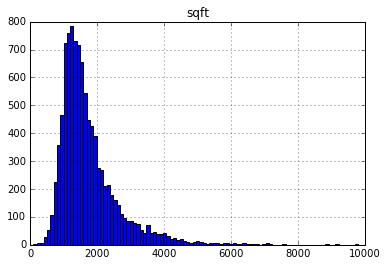

In [38]:
DF_CA = SF_CA_14[SF_CA_14['sqft'] > 0][['sqft']].to_dataframe()
DF_CA.hist(column = 'sqft', color = 'blue', bins = 100, range = (100,10000))
print 'average sqft is ', np.mean(DF_CA['sqft'])
print 'median sqft is ', np.median(DF_CA['sqft'])


## What assumptions would you be making if you tried to estimate the average age of homes in California from this data set?

Assumption 1: this transaction sample is an unbiased sample of all the transaction data.

Assumption 2: people selling and buying property are not conditioned on the house's age. In another word, the probabilities of either a older house or a newer house to be sold are the same.

Assumption 3: people have no preference on property's age 

## What does the model you built in Part 2 tell you about how much a borrower is likely to make if they rehab a property? What additional data might be useful for this problem?

My model tells me if a investor is going to upgrade the property's' foundation to concrete and construction to wood, he will make about 26.25% of profit (17.5% + 34.7% - 26.1%) and this value will be different based on different property type.

It would be really good if we can have property's location data (zip code or MSA, CBSA), local per capita income, local demographica data, crime rate data, house style data, property inspection data (property condition).

# Bonus part

## Something interesting about this data set.

(1) Texas people is this data doesn't make much of money from re-sale their property (hope my hiring manager is not from Texas :P)

(2) There is someone that messed up the data (intentinally? :)) on at least the purchase_price column. There are quite a lot 0s, but loan_amt is not 0. We can use other non-zero purchase price and loan_amt to get average loan-to-value ratio, then re-calculate purchase_price.

(3) There are some transactions with loan_amt larger than the purchase price. Maybe sub-prime again? :)
 

## Something interesting about market LendingHome operates in

For loans with mortgage insurances, Quicken doesn't only makes money from the bps differences between originating and seliing but also makes money from mortgage insurance.

For high LTV loans or loan portfolio, I know how their mortgage insurances is priced.

# Thoughts for Improvement:
    (1) There are more features in the data for me to slice and dice and plots should be improved on delivering more more useful informationa
    (2) There are more modle features to explore and explain.
    (3) Too few resale data points and want to work on the full set